# Parsing Objectron's SequenceExamples

This tutorial shows how to use the Objectron [SequenceExamples](https://github.com/tensorflow/tensorflow/blob/fcc4b966f1265f466e82617020af93670141b009/tensorflow/core/example/example.proto#L300). Unlike our normal tf.examples where each example holds a single image frame with annotation, SequenceExamples hold the entire video sequence and corresponding annotation in them. These files are useful for training video models, multi-view models, as well as tracking objects in 3D across multiple frames.

In [22]:
objectron_buckett = 'gs://objectron'
# Importing the necessary modules. We will run this notebook locally.

import tensorflow as tf
import glob
from IPython.core.display import display,HTML
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from objectron.schema import features
from objectron.dataset import box
from objectron.dataset import graphics

Every sequence example has two parts: context and feature lists. The context are sequence attributes which apply to the entire sequence. In our SequenceExamples, context contains two items: 1) `count`, the number of frames in the sequence, and 2) `sequence_id`, a string field in the format of `class/batch-i/j`. 

The sequence features contains the list of the features in the sequence. They are very similar as the tf.examples used in the Hello World notebook. Except each field is a list of the size `count` of that feature. The feature_lists contain a key, value map where each key is associated with a repeated set of Features (a FeatureList).
See `objectron/schema/features.py` for more information.

See [`parse_single_sequence_example API`](https://www.tensorflow.org/api_docs/python/tf/io/parse_single_sequence_example) for more details.

In our dataset, sequence examples are located in `/objectron/v1/sequences/class/class_test*` and `class_train*`, where the class in one of the object categories. (`bike, book, bottle, camera, cereal_box, chair, cup, laptop, shoe`). Keep in mind each sequence example corresponds to a single video file, so the iterator over the entire dataset will produce total number of videos in the dataset (about 2000 video per class) before repeating the data. So make sure the your data pipelines include `.repeat()`. 

In [25]:
# Data pipeline for parsing the sequence examples. In this example, we grab a few frames from each sequence.

NUM_KEYPOINTS = 9
NUM_FRAMES = 4

def parse_tfrecord(example):
    context, data = tf.io.parse_single_sequence_example(
                            example, 
                            sequence_features = features.SEQUENCE_FEATURE_MAP,
                            context_features = features.SEQUENCE_CONTEXT_MAP
                        )
    
    # Number of frames in this video sequence
    num_examples = context['count']
    # The unique sequence id (class/batch-i/j) useful for visualization/debugging
    video_id = context['sequence_id']
    
    rand = tf.random.uniform([NUM_FRAMES], 0, num_examples, tf.int64)
    data['frame_ids'] = rand
    # Grab 4 random frames from the sequence and decode them
    for i in range(NUM_FRAMES):
        id = rand[i]
        image_tag = 'image-{}'.format(i)
        data[image_tag] = data[features.FEATURE_NAMES['IMAGE_ENCODED']][id]
        data[image_tag] = tf.image.decode_png(data[image_tag], channels=3)
        data[image_tag].set_shape([640, 480, 3])
    return context, data

shards = tf.io.gfile.glob(objectron_buckett + '/v1/sequences/book/book_train*')

dataset = tf.data.TFRecordDataset(shards)
dataset = Dataset.map(parse_tfrecord)



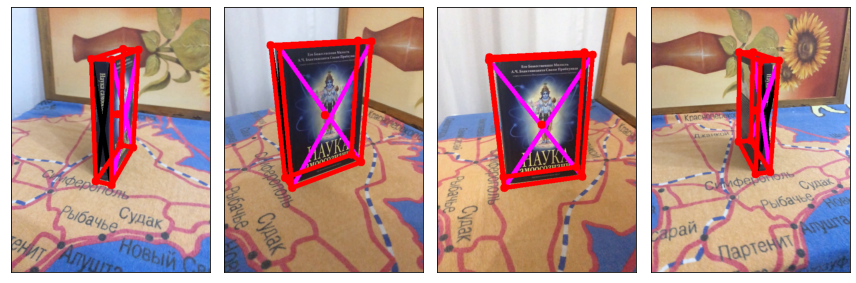

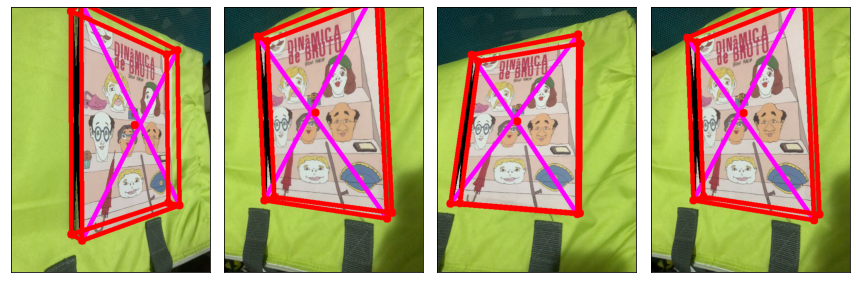

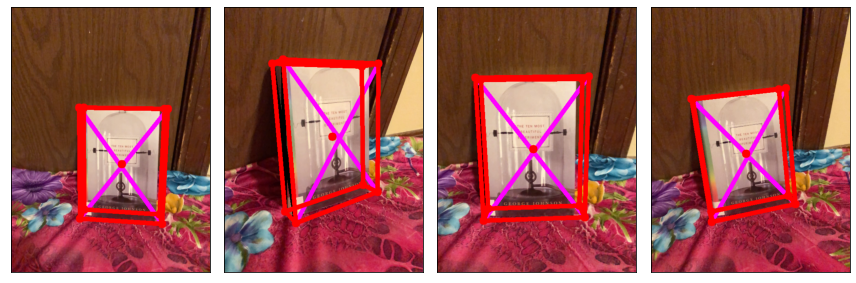

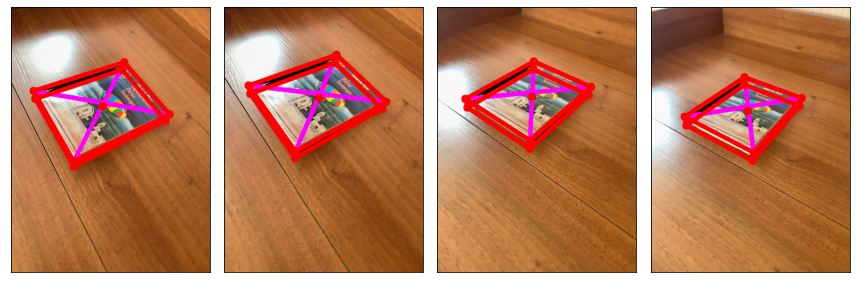

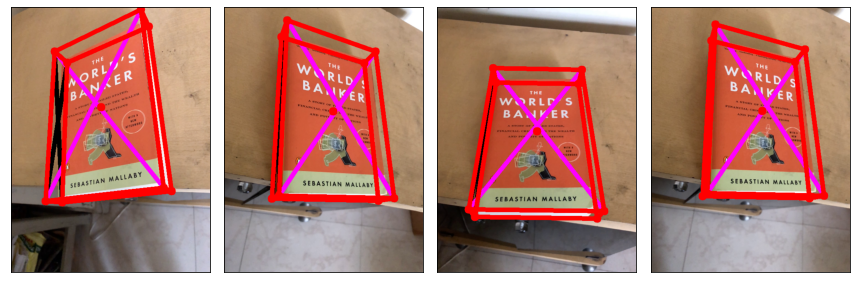

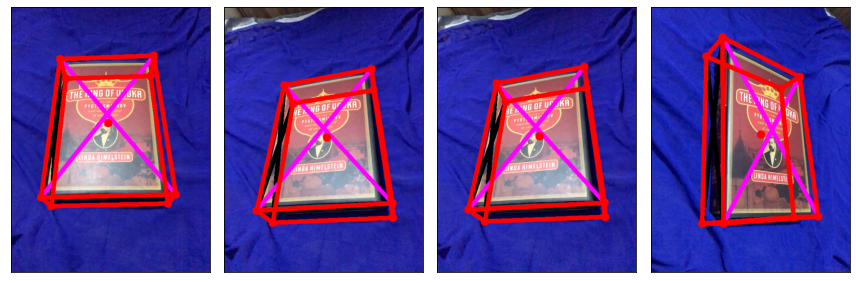

In [33]:
num_rows = 10
for context, data in dataset.take(num_rows):
    fig, ax = plt.subplots(1, NUM_FRAMES, figsize = (12, 16))
    
    for i in range(NUM_FRAMES):
        num_frames = context['count']
        id = data['frame_ids'][i]
        image = data['image-{}'.format(i)].numpy()
        num_instances = data[features.FEATURE_NAMES['INSTANCE_NUM']][id].numpy()[0]
        keypoints = data[features.FEATURE_NAMES['POINT_2D']].values.numpy().reshape(num_frames, num_instances, NUM_KEYPOINTS, 3)
        for instance_id in range(num_instances):
            image = graphics.draw_annotation_on_image(image, keypoints[id, instance_id, :, :], [9])
        ax[i].grid(False)
        ax[i].imshow(image);
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        
    fig.tight_layout();
    plt.show()